# 쇼핑몰 마켓 접근

In [78]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import sys
import time
driver = webdriver.Chrome('./chromedriver')
driver.set_window_size(600,800)
driver.implicitly_wait(3)
driver.get('https://www.brandi.co.kr/category')

<html lang="ko"><head><meta charset="utf-8"/><title>브랜디 - 여성 전문 쇼핑앱</title><meta content="width=device-width,initial-scale=1,minimum-scale=1,maximum-scale=3" name="viewport"/><meta content="오직 예쁜 옷만 모으다! 여성의류 쇼핑몰, 블로그마켓, 스트릿, 디자이너 브랜드 편집샵" name="description" property="description"/><meta content="브랜디 - 여성 전문 쇼핑앱" name="og:title" property="og:title"/><meta content="오직 예쁜 옷만 모으다! 여성의류 쇼핑몰, 블로그마켓, 스트릿, 디자이너 브랜드 편집샵" name="og:description" property="og:description"/><meta content="https://www.brandi.co.kr/static/3.50.2/images/og-brandi.jpg" name="og:image" property="og:image"/><meta content="브랜디" name="al:ios:app_name" property="al:ios:app_name"/><meta content="1005442353" name="al:ios:app_store_id" property="al:ios:app_store_id"/><meta content="brandiapplication://applink" name="al:ios:url" property="al:ios:url"/><meta content="브랜디" name="al:android:app_name" property="al:android:app_name"/><meta content="com.brandicorp.brandi3" name="al:android:package" property="al:android:package"/><met
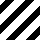

In [10]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
print(soup)

# 크롤링 공통

In [114]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

data = {}
#크롤링할 카테고리갯수
cate_num= 5
how_many = 20
sleep = 3
brand_cate = ['/categories/all', '/categories/all/brand','/categories/all/beauty']


for i in brand_cate:
    #브랜드 카테고리
    data['brand_cate'] = re.findall(r'(.*)\n',soup.select('.menu_title')[1].get_text())[0]
    link = 'https://www.brandi.co.kr' + i
    driver.get(link)
    time.sleep(sleep)
    
    #아우터 클릭로 스왑
    for j in range(cate_num):
        button = driver.find_element_by_xpath(f"//ul[@id='sub_gnb']/li[{j+1}]/a")
        driver.execute_script("arguments[0].click();", button)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        #카테고리
        data['category'] = soup.select('li[data-v-1cf382de] a.active span')[0].get_text()
        sub_cate = soup.select('tr[data-v-506e5306] td')
        for k in range(1,len(sub_cate)):
            #서브카테고리
            data['sub_category'] = sub_cate[k].get_text().strip()
            #서브카테고리 클릭
            button = driver.find_element_by_xpath(f"//tr[@data-v-506e5306]/td[{k+1}]")
            driver.execute_script("arguments[0].click();", button)
            
            #서브카테고리에서 제품 입장
            for l in range(how_many):
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                link = 'https://www.brandi.co.kr' + soup.select('.list_full a')[l].get('href')
                
                #제품 입장
                driver.get(link)
                time.sleep(sleep)
                soup = BeautifulSoup(driver.page_source, 'html.parser')


                #메인 이미지
                img = soup.select_one('.swiper-wrapper').select('[data-thumb]')
                data['main_img'] = [n['data-thumb'] for n in img] 
                #브랜드 이미지
                brand_img = soup.select_one('.seller-info div')
                data['brand_img'] = re.findall(r'url[(]["](.*)["]',brand_img['style'])[0]
                #브랜드 이름
                data['brandname'] = soup.select_one('.info strong.name').get_text()
                #브랜드 소개
                data['intro'] = soup.select_one('.info p.txt').get_text()
                #제품 이름
                data['title'] = soup.select_one('.detail_title').get_text()
                #할인율
                try:
                    discount = soup.select_one('strong.dc').get_text()
                    data['discount_rate'] = int(re.findall(r'\d*',discount)[0].replace('%',''))
                except:
                    data['discount_rate'] =  0
                #제품가격
                try:
                    data['price'] = int(soup.select_one('.detail_price .cost .number').get_text().replace(',',''))
                except:
                    data['price'] = int(soup.select_one('.detail_price .price .number').get_text().replace(',',''))
                #판매량
                try :
                    count = soup.select_one('.total-sales').get_text()
                    try:
                        Purchase_count = int(re.findall(r'\d*[,]\d*',count)[0].replace(',',''))
                    except:
                        Purchase_count = int(re.findall(r'\d*',count)[0])
                except:
                    Purchase_count = 0
                data['sales_count'] = Purchase_count
                #배송정보
                data['delivery'] = soup.select_one('.conts-more dd').get_text()
                #product_text
                data['info_text'] = soup.select_one('#info_container_1').get_text().replace('\n', '')
                #product_img
                img = soup.select('#info_container_1 img')
                data['info_img'] = [n['src'] for n in img]

                #스토어 정보 - 상호명,대표자,사업자등록번호,통신판매업번호,사업장소재지
                info = soup.select('p.txt-info')
                slist = ['company_name','representative','license_num','mail_order_num','biz_location']
                for num,field in enumerate(slist):
                    var = info[num].get_text().replace('\n',"")
                    data[field] = re.findall(r'[:]\s*(.*)',var)[0].rstrip()
                #스토어 고객센터 - 영업시간,이메일,전화번호
                data['business_hour'] = soup.select('p.txt-info')[5].get_text()
                slist = ['company_email','company_call']
                for num,field in enumerate(slist):
                    var = info[num+6].get_text().replace('\n',"")
                    data[field] = re.findall(r'[:]\s*(.*)',var)[0].rstrip()
                #모델 사이즈 정보
                if soup.find('h4', text="[ 모델 사이즈 정보 ]"):
                    for l in range(8,12):
                        data['model_size'] = data.get('model_size','') + info[l].get_text().replace('\n',"") + '\n'
                #배송정보     
                var = soup.select('h4')[4].parent.select('[data-v-4ced9216]')
                count = 0
                page = 1
                for l in var:

                    if re.match('<h4',str(l)):

                        if count == page :
                            break
                        count+=1
                        continue
                    if count == page:
                        data['shipping_info'] = data.get('shipping_info','') + l.get_text() + '\n'

                #교환/환불정보
                count = 0
                page=2
                for l in var:

                    if re.match('<h4',str(l)):

                        if count == page :
                            break
                        count+=1
                        continue
                    if count == page:
                        data['exchange_refund_info'] = data.get('exchange_refund_info','') + l.get_text() + '\n'


                #뒤로가기
                driver.back()
                time.sleep(sleep)

                print(data)
                sys.exit()
    driver.back()
    time.sleep(sleep)
#         driver.execute_script("arguments[0].click();", button)
#         html = driver.page_source
#         soup = BeautifulSoup(html, 'html.parser')

{'brand_cate': '브랜드', 'category': '아우터', 'sub_category': '자켓', 'main_img': ['https://image.brandi.me/cproduct/2020/06/04/17082238_1591255536_image1_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255429_image2_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255431_image3_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255432_image4_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255434_image5_L.jpg'], 'brand_img': 'https://image.brandi.me/seller/moodglam_profile_1523930002.jpeg', 'brandname': '무드글램', 'intro': '고민은 배송만 늦출뿐 !', 'title': 'vivi 반팔자켓 린넨자켓 2col_무드글램', 'discount_rate': 0, 'price': 18700, 'sales_count': 2011, 'delivery': '브랜디 배송', 'info_text': "[MD comment]오픈해서 입기도 멋스럽고전체를 잠궈도 스타일리쉬한느낌의반팔자켓이에요 :)색감도 밝아서어느하의나 잘어울린답니다^^패드 O(탈부착불가능)[color] 베이지 소라[fabric] 면 70 린넨 30[made in]한국[production date] 2020 S/S[size] F 위의 실측사이즈는 '단면의 길이'입니다. 참고해 주세요. 사이즈는 측정방법에 따라 1~3cm 정도 오차가 있을 수 있습니다. 제품색상은 사용자의 모니터의 해상도에 따라 실제 색상과 

SystemExit: 

In [115]:
print(data)

{'brand_cate': '브랜드', 'category': '아우터', 'sub_category': '자켓', 'main_img': ['https://image.brandi.me/cproduct/2020/06/04/17082238_1591255536_image1_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255429_image2_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255431_image3_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255432_image4_L.jpg', 'https://image.brandi.me/cproduct/2020/06/04/17082238_1591255434_image5_L.jpg'], 'brand_img': 'https://image.brandi.me/seller/moodglam_profile_1523930002.jpeg', 'brandname': '무드글램', 'intro': '고민은 배송만 늦출뿐 !', 'title': 'vivi 반팔자켓 린넨자켓 2col_무드글램', 'discount_rate': 0, 'price': 18700, 'sales_count': 2011, 'delivery': '브랜디 배송', 'info_text': "[MD comment]오픈해서 입기도 멋스럽고전체를 잠궈도 스타일리쉬한느낌의반팔자켓이에요 :)색감도 밝아서어느하의나 잘어울린답니다^^패드 O(탈부착불가능)[color] 베이지 소라[fabric] 면 70 린넨 30[made in]한국[production date] 2020 S/S[size] F 위의 실측사이즈는 '단면의 길이'입니다. 참고해 주세요. 사이즈는 측정방법에 따라 1~3cm 정도 오차가 있을 수 있습니다. 제품색상은 사용자의 모니터의 해상도에 따라 실제 색상과 

In [121]:
import json
import os
with open('result.json', 'w+') as json_file:
    json.dump(data, json_file)

In [99]:
    button = driver.find_element_by_xpath("//ul[@id='sub_gnb']/li[2]/a")
    driver.execute_script("arguments[0].click();", button)

In [52]:
button = driver.find_element_by_xpath("//ul[@id='sub_gnb']/li[2]/a")
driver.execute_script("arguments[0].click();", button)

In [71]:
k=1
button = driver.find_element_by_xpath(f"//tr[@data-v-506e5306]/td[{k+1}]")
driver.execute_script("arguments[0].click();", button)

In [ ]:



for i in range(3):
    #메인카테고리
    data['category'] = re.findall(r'(.*)\n',soup.select('.menu_title')[i].get_text())[0]
    sub_cate = soup.select('ul[data-v-867c5692]')[i].select('li')
    for j in range(1,len(sub_cate)):
        #서브카테고리
        data['sub_category'] = sub_cate[j].get_text()
        link = 'https://www.brandi.co.kr' + sub_cate[j].a.get('href')
        driver.get(link)
        time.sleep(sleep)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for k in range(how_many):
            p_link = 'https://www.brandi.co.kr' + soup.select('.list_full a')[k].get('href')
            driver.get(p_link)
            time.sleep(sleep)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            
            #제품 입장
            
            #메인 이미지
            img = soup.select_one('.swiper-wrapper').select('[data-thumb]')
            data['main_img'] = [n['data-thumb'] for n in img] 
            #브랜드 이미지
            brand_img = soup.select_one('.seller-info div')
            data['brand_img'] = re.findall(r'url[(]["](.*)["]',brand_img['style'])[0]
            #브랜드 이름
            data['brandname'] = soup.select_one('.info strong.name').get_text()
            #브랜드 소개
            data['intro'] = soup.select_one('.info p.txt').get_text()
            #제품 이름
            data['title'] = soup.select_one('.detail_title').get_text()
            #할인율
            try:
                discount = soup.select_one('strong.dc').get_text()
                data['discount_rate'] = int(re.findall(r'\d*',discount)[0].replace('%',''))
            except:
                data['discount_rate'] =  0
            #제품가격
            try:
                data['price'] = int(soup.select_one('.detail_price .cost .number').get_text().replace(',',''))
            except:
                data['price'] = int(soup.select_one('.detail_price .price .number').get_text().replace(',',''))
            #판매량
            try :
                count = soup.select_one('.total-sales').get_text()
                try:
                    Purchase_count = int(re.findall(r'\d*[,]\d*',count)[0].replace(',',''))
                except:
                    Purchase_count = int(re.findall(r'\d*',count)[0])
            except:
                Purchase_count = 0
            data['sales_count'] = Purchase_count
            #배송정보
            data['delivery'] = soup.select_one('.conts-more dd').get_text()
            #product_text
            data['info_text'] = soup.select_one('#info_container_1').get_text().replace('\n', '')
            #product_img
            img = soup.select('#info_container_1 img')
            data['info_img'] = [n['src'] for n in img]
            
            #스토어 정보 - 상호명,대표자,사업자등록번호,통신판매업번호,사업장소재지
            info = soup.select('p.txt-info')
            slist = ['company_name','representative','license_num','mail_order_num','biz_location']
            for num,field in enumerate(slist):
                var = info[num].get_text().replace('\n',"")
                data[field] = re.findall(r'[:]\s*(.*)',var)[0].rstrip()
            #스토어 고객센터 - 영업시간,이메일,전화번호
            data['business_hour'] = soup.select('p.txt-info')[5].get_text()
            slist = ['company_email','company_call']
            for num,field in enumerate(slist):
                var = info[num+6].get_text().replace('\n',"")
                data[field] = re.findall(r'[:]\s*(.*)',var)[0].rstrip()
            #모델 사이즈 정보
            if soup.find('h4', text="[ 모델 사이즈 정보 ]"):
                for l in range(8,12):
                    data['model_size'] = data.get('model_size','') + info[l].get_text().replace('\n',"") + '\n'
            #배송정보     
            var = soup.select('h4')[4].parent.select('[data-v-4ced9216]')
            count = 0
            page = 1
            for l in var:

                if re.match('<h4',str(l)):

                    if count == page :
                        break
                    count+=1
                    continue
                if count == page:
                    data['shipping_info'] = data.get('shipping_info','') + l.get_text() + '\n'
                    
            #교환/환불정보
            count = 0
            page=2
            for l in var:

                if re.match('<h4',str(l)):

                    if count == page :
                        break
                    count+=1
                    continue
                if count == page:
                    data['exchange_refund_info'] = data.get('exchange_refund_info','') + l.get_text() + '\n'


            #뒤로가기
            driver.back()
            time.sleep(sleep)
            
            print(data)
            sys.exit()

# 크롤링 부품

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import sys
driver = webdriver.Chrome('./chromedriver')
driver.set_window_size(600,800)
driver.implicitly_wait(3)
driver.get('https://www.brandi.co.kr/category/all')


In [ ]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
a = soup.select()

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
driver = webdriver.Chrome('./chromedriver')
driver.set_window_size(600,800)
driver.get('https://www.brandi.co.kr/products/19128952')


In [ ]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
img = soup.select_one('.swiper-wrapper').select('[data-thumb]')

print([ n['data-thumb'] for n in img]) 

In [ ]:
brandimg = soup.select_one('.seller-info div')
print(re.findall(r'url[(]["](.*)["]',brandimg['style'])[0])

In [ ]:
brandname = soup.select_one('.info strong.name').get_text()
print(brandname)

In [ ]:
intro = soup.select_one('.info p.txt').get_text()
print(intro)

In [ ]:
title = soup.select_one('.detail_title').get_text()
print(title)

In [ ]:
try:
    data = soup.select_one('strong.dc').get_text()
    discountRate = int(re.findall(r'\d*',data)[0].replace('%',''))
except:
    discountRate = 0

print(discountRate)

In [ ]:
try:
    data = int(soup.select_one('.detail_price .cost .number').get_text().replace(',',''))
except:
    data = int(soup.select_one('.detail_price .price .number').get_text().replace(',',''))
print(data)

In [ ]:
try :
    data = soup.select_one('.total-sales').get_text()
    try:
        Purchase_count = int(re.findall(r'\d*[,]\d*',data)[0].replace(',',''))
    except:
        Purchase_count = int(re.findall(r'\d*',data)[0])
except:
    Purchase_count = 0
print(Purchase_count)

In [ ]:
delivery = soup.select_one('.conts-more dd').get_text()
print(delivery)

In [ ]:
# 색
# option = soup.select('.detail_options option')
# for i in option:
#     print(i['value'])



In [ ]:
info_img = soup.select('#info_container_1 img')
for i in info_img:
    print(i['src'])

In [ ]:
# textdic = {}
# info_text = [i for i in soup.select_one('#info_container_1').get_text().splitlines() if i]
# for i in info_text:
#     if i == '\xa0' or i == '\u200b':
#         i = ' '
#     textdic['comment'] = textdic.get('comment','') + i
# print(textdic)

In [ ]:
info_text = soup.select_one('#info_container_1').get_text().replace('\n', '')
print(info_text)

In [ ]:
name = soup.select('p.txt-info')
for i in range(5):
    var = name[i].get_text().replace('\n',"")
    print(re.findall(r'[:]\s*(.*)',var)[0].rstrip())
    break
   

In [ ]:
data = {}
name = soup.select('p.txt-info')
slist = ['company_name','representative','license_num','mail_order_num','biz_location']
for num,field in enumerate(slist):
    var = name[num].get_text().replace('\n',"")
    data[field] = re.findall(r'[:]\s*(.*)',var)[0].rstrip()
print(data)

In [ ]:
name = soup.select('p.txt-info')[5].get_text()
print(name)

In [ ]:
name = soup.select('p.txt-info')[5].get_text()
print(name)
name = soup.select('p.txt-info')
for i in range(6,8):
    var = name[i].get_text().replace('\n',"")
    print(re.findall(r'[:]\s*(.*)',var)[0].rstrip())

In [ ]:
data = {}
if soup.find('h4', text="[ 모델 사이즈 정보 ]"):
    name = soup.select('p.txt-info')
    for i in range(8,12):
        var = name[i].get_text().replace('\n',"")
        data['model_size'] = data.get('model_size','') + var + '\n'
        
print(data)

In [ ]:
n = soup.select('h4')[4].parent.select('[data-v-4ced9216]')
count = 0
page = 1
for i in n:
    
    if re.match('<h4',str(i)):
        
        if count == page :
            break
        count+=1
        continue
    if count == page:
        print(i.get_text())

In [ ]:
n = soup.select('h4')[4].parent.select('[data-v-4ced9216]')
count = 0
page = 2
for i in n:
    
    if re.match('<h4',str(i)):
        
        if count == page :
            break
        count+=1
        continue
    if count == page:
        print(i.get_text())

In [ ]:
name = soup.select('#seller-order-info td')[4].get_text()
print(name)

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
driver = webdriver.Chrome('./chromedriver')
driver.get('https://www.brandi.co.kr/products/18814376')
driver.implicitly_wait(7)
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
print(soup)

In [ ]:
data = {}
#메인 이미지 +++++++++++++++이미지 리사이징 필요
img = list(set(soup.select('img[data-v-e6eb87de]')))
data['main_img'] = [n['src'] for n in img]
#브랜드 이름
data['brandname'] = soup.select('a[data-v-c8060bfa]')[1].get_text()
#브랜드 소개
data['intro'] = soup.select('a[data-v-c8060bfa]')[2].get_text()
#제품 이름
data['name'] = soup.select_one('.detail_title').get_text()
#제품 가격
try:
    var = soup.select_one('.detail_price span').get_text()
except:
    var = soup.select_one('.detail_price').get_text()
data['price'] = int(re.findall(r'\d*[,]\d*',var)[0].replace(',',''))
#할인율
try:
    var = soup.select_one('.detail_price b').get_text()
    data['discount_rate'] = int(re.findall(r'\d*',var)[0].replace('%',''))/100
except:
    data['discount_rate'] = 0
#판매량
try :
    var = soup.select_one('.detail_purchase_count').get_text()
    try:
        Purchase_count = int(re.findall(r'\d*[,]\d*',var)[0].replace(',',''))
    except:
        Purchase_count = int(re.findall(r'\d*',var)[0])
except:
    Purchase_count = 0
#배송정보
data['delivery'] = soup.select_one('.detail_info_wrapper > span').get_text()[5:]

#product_detail
data['detail'] = soup.select_one('#info_container_1').get_text().replace('\n', '')

#product_detail_img
img = soup.select('#info_container_1 img')
data['info_img'] = [n['src'] for n in img]

#주문정보로 스왑
button = driver.find_element_by_xpath(f'//div[@class="tab_default"][3]')
driver.execute_script("arguments[0].click();", button)
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

#스토어정보
store_info = soup.select('#store-info td')
#주문정보
selling_info = soup.select('#seller-order-info td')
#상호명이 브랜디이면 모델사이즈 제외 전부 기본값
company_name = store_info[1].get_text()

if company_name == '주식회사 브랜디':
    if soup.select('#seller-order-info th')[1].get_text() == '모델 사이즈 정보':
        data['model_size'] = selling_info[1].get_text()

else:
    data['company_name'] = company_name
    #대표자
    data['representative'] = store_info[3].get_text()
    #사업자등록번호
    data['license_num'] = store_info[5].get_text()
    #통신판매업번호
    data['mail_order_num'] = store_info[7].get_text()
    #사업장소재지
    data['biz_location'] = store_info[9].get_text()


    n = 0
    #스토어 고객센터
    data['biz_location'] = selling_info[n].get_text()
    n+=1
    #모델사이즈 정보 // 없으면 스킵
    if soup.select('#seller-order-info th')[1].get_text() == '모델 사이즈 정보':
        data['model_size'] = selling_info[n].get_text()
        n+=1
    #배송정보
    data['shipping_info'] = selling_info[n].get_text()
    n+=1
    #교환/환불정보
    data['exchange_refund_info'] = selling_info[n].get_text()
    n+=1
    #상품정보 고시
    var = selling_info[n].get_text()
    if var == '상품상세 참조':
        pass
    else:
        data['product_notice'] = var
        
print(data)

In [ ]:
dic = {}

dic['a'] = 34
print(dic)

In [ ]:
data = {'1':'1234'}
data['2']

In [ ]:
# # import sys
# li = soup.select('.swiper li[data-v-f4bbec10]')
# data = {}
# # count = 0
# for i in li:
#     cate = i.select('a')
#     main_cate = cate[0].get_text()
#     #메인카테고리
#     data['category'] = main_cate
#     for j in range(1,len(cate)):
#         #서브카테고리
#         data['sub_category'] = cate[j].get_text()
#         link = ('https://www.brandi.co.kr' + cate[j].get('href'))
#         driver.get(link)
#         html = driver.page_source
#         soup = BeautifulSoup(html, 'html.parser')
#         for k in range(20):
#             p_link = 'https://www.brandi.co.kr' + soup.select('a[data-v-6fea5b78]')[k].get('href')
#             driver.get(p_link)
#             html = driver.page_source
#             soup = BeautifulSoup(html, 'html.parser')
#             #메인 이미지 +++++++++++++++이미지 리사이징 필요
#             img = list(set(soup.select('img[data-v-e6eb87de]')))
#             data['main_img'] = [n['src'] for n in img]
#             #브랜드 이름
#             data['brandname'] = soup.select('a[data-v-c8060bfa]')[1].get_text()
#             #브랜드 소개
#             data['intro'] = soup.select('a[data-v-c8060bfa]')[2].get_text()
#             #제품 이름
#             data['name'] = soup.select_one('.detail_title').get_text()
#             #제품 가격
#             try:
#                 var = soup.select_one('.detail_price span').get_text()
#             except:
#                 var = soup.select_one('.detail_price').get_text()
#             data['price'] = int(re.findall(r'\d*[,]\d*',var)[0].replace(',',''))
#             #할인율
#             try:
#                 var = soup.select_one('.detail_price b').get_text()
#                 data['discount_rate'] = int(re.findall(r'\d*',var)[0].replace('%',''))/100
#             except:
#                 data['discount_rate'] = 0
#             #판매량
#             try :
#                 var = soup.select_one('.detail_purchase_count').get_text()
#                 try:
#                     Purchase_count = int(re.findall(r'\d*[,]\d*',var)[0].replace(',',''))
#                 except:
#                     Purchase_count = int(re.findall(r'\d*',var)[0])
#             except:
#                 Purchase_count = 0
#             data['sales_count'] = Purchase_count
#             #배송정보
#             data['delivery'] = soup.select_one('.detail_info_wrapper > span').get_text()[5:]

#             #product_detail
#             data['info_text'] = soup.select_one('#info_container_1').get_text().replace('\n', '')

#             #product_detail_img
#             img = soup.select('#info_container_1 img')
#             data['info_img'] = [n['src'] for n in img]
            
#             #주문정보로 스왑
#             button = driver.find_element_by_xpath(f'//div[@class="tab_default"][3]')
#             driver.execute_script("arguments[0].click();", button)
#             html = driver.page_source
#             soup = BeautifulSoup(html, 'html.parser')
            
#             #스토어정보
#             store_info = soup.select('#store-info td')
#             #주문정보
#             selling_info = soup.select('#seller-order-info td')
#             #상호명이 브랜디이면 모델사이즈 제외 전부 기본값
#             company_name = store_info[1].get_text()
            
#             if company_name == '주식회사 브랜디':
#                 if soup.select('#seller-order-info th')[1].get_text() == '모델 사이즈 정보':
#                 data['model_size'] = selling_info[1].get_text()

#             else:
#                 data['company_name'] = company_name
#                 #대표자
#                 data['representative'] = store_info[3].get_text()
#                 #사업자등록번호
#                 data['license_num'] = store_info[5].get_text()
#                 #통신판매업번호
#                 data['mail_order_num'] = store_info[7].get_text()
#                 #사업장소재지
#                 data['biz_location'] = store_info[9].get_text()
            

#                 n = 0
#                 #스토어 고객센터
#                 data['biz_location'] = selling_info[n].get_text()
#                 n+=1
#                 #모델사이즈 정보 // 없으면 스킵
#                 if soup.select('#seller-order-info th')[1].get_text() == '모델 사이즈 정보':
#                     data['model_size'] = selling_info[n].get_text()
#                     n+=1
#                 #배송정보
#                 data['shipping_info'] = selling_info[n].get_text()
#                 n+=1
#                 #교환/환불정보
#                 data['exchange_refund_info'] = selling_info[n].get_text()
#                 n+=1
#                 #상품정보 고시
#                 var = selling_info[n].get_text()
#                 if var == '상품상세 참조':
#                     pass
#                 else:
#                     data['product_notice'] = var

#             print(data)
#             sys.exit(1)


        